# Обробка даних у базі даних: SELECT, INSERT, UPDATE, DELETE за допомогою Python

Будемо працювати з базою даних Employees 

Репозиторій з дампами цієї бази: https://github.com/datacharmer/test_db  
Структура бази: https://dev.mysql.com/doc/employee/en/sakila-structure.html  

Після встановлення MySQL локально, я додала шлях до /usr/local/mysql/bin/ в змінну PATH та тоді змогла отримати доступ до виконання команди в терміналі:

In [ ]:
%%bash
export PATH=$PATH:/usr/local/mysql/bin
mysql --version

Щоб створити локально базу employees - в **терміналі**
1. клонуємо репозиторій `git clone https://github.com/datacharmer/test_db.git`
2. в папці репозиотрію `test_db` запускаємо команду `mysql -u root -p < employees.sql`  

Після цього в терміналі має надрукуватись щось таке - це означає, що всі таблиці успішно завантажились:

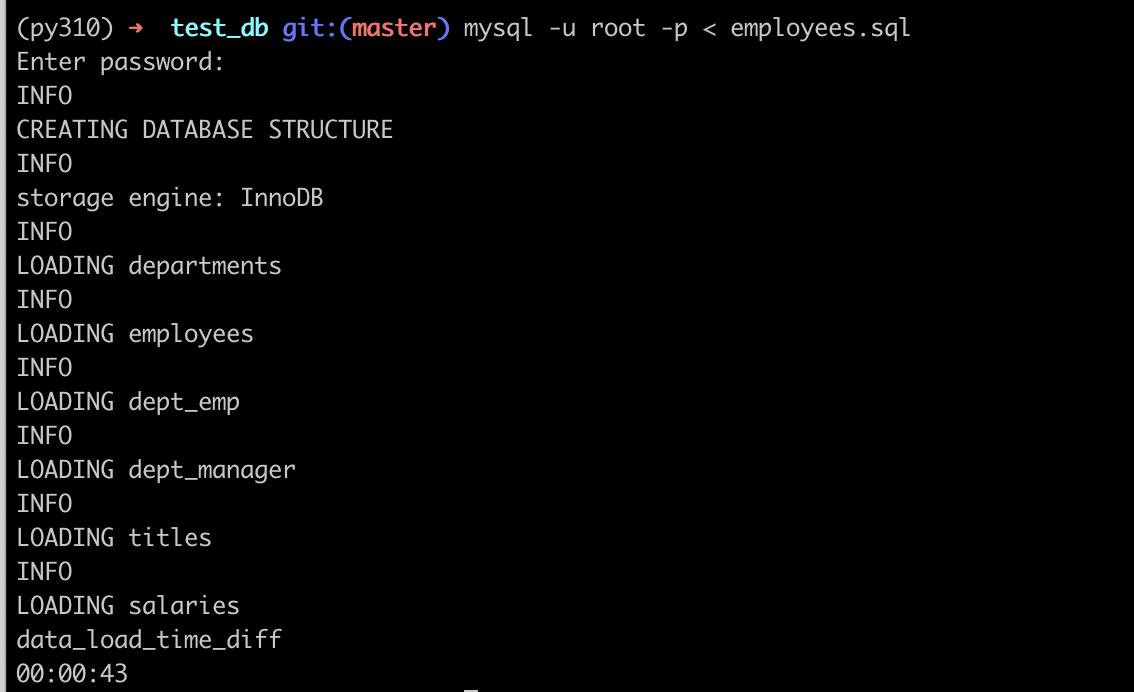

Щоб під'єднатися до консолі mysql - необхыдно виконати в терміналі наступну команду та ввести пароль:

In [ ]:
%bash
mysql -u root -p
# my password: perfection

Ви можете самостійно потренуватись робити запити в консолі. А ми рухаємось далі і будемо вчитись підключати Python до SQL.

Установимо конектор до mysql бази для Python:

In [ ]:
!pip install mysql-connector-python

In [ ]:
! conda list | grep mysql-connector-python

Туторіали для роботи з MySQL з Python: https://dev.mysql.com/doc/connector-python/en/connector-python-examples.html

In [ ]:
import mysql.connector
from mysql.connector.connection import MySQLConnection
import datetime

# Employees database

## Create connection

Підключення до бази.

In [ ]:
con = mysql.connector.connect(user='root', password='perfection',
                              host='127.0.0.1',
                              database='employees')

## SELECT

In [ ]:
cursor = con.cursor()

In [ ]:
sql = """
SELECT first_name, last_name, hire_date 
FROM employees 
WHERE hire_date BETWEEN %s AND %s LIMIT 10
"""

In [ ]:
sql

In [ ]:
hire_start = datetime.date(1999, 1, 1)
hire_end = datetime.date(1999, 1, 15)

In [ ]:
cursor.execute(sql, (hire_start, hire_end))

In [ ]:
# dir(cursor)

Відсотки в запитах означають, що в цих місцях ми очікуємо змінний рядок. Такий запит називається параметризованим. Приклад, як працює підстановка рядка в шаблон у Python:

In [ ]:
str_template = 'Hi! My name is %s.'

In [ ]:
str_template % 'John'

Альтернативно можна було б зробити з таким форматуванням:

In [ ]:
cursor = con.cursor()

sql ="""
SELECT first_name, last_name, hire_date FROM employees 
WHERE hire_date BETWEEN '{}' AND '{}' LIMIT 10
"""

cursor.execute(sql.format(hire_start, hire_end))

Після `execute` курсор став генератором, який містить усі записи, які повернув запит `select`. Так ми отримаємо наступний черговий запис:

In [ ]:
next(cursor)

І наступний запис:

In [ ]:
next(cursor)

Альтернативні способи отримати кілька записів з курсора за раз:

In [ ]:
cursor.fetchmany(3)

Після цієї команди курсор вже буде пустим і вже ми з нього нічого не отримаємо (треба перестворити курсор і додати туди дані, аби спробувати отримати дані, наприклад, в циклі нижче):

In [ ]:
cursor.fetchall()

In [ ]:
for (first_name, last_name, hire_date) in cursor:
    print("{}, {} was hired on {:%d %b %Y}".format(last_name, first_name, hire_date))

Зараз генератор уже порожній, тому `next` поверне помилку `StopIteration`:

In [ ]:
next(cursor)

Наприкінці роботи з курсором, його треба закрити.

In [ ]:
cursor.close()

### Читання даних за допомогою Pandas

In [ ]:
import pandas as pd

In [ ]:
sql = """
SELECT first_name, last_name, hire_date 
FROM employees 
WHERE hire_date BETWEEN %s AND %s LIMIT 10
"""

In [ ]:
type(con)

In [ ]:
df = pd.read_sql(sql, con, params=(hire_start, hire_end), parse_dates='hire_date')

Альтернативний спосіб читати дані з параметризованого запита, коли він параметризований іншим способом (format):

In [ ]:
sql_2 ="""
SELECT first_name, last_name, hire_date FROM employees 
WHERE hire_date BETWEEN '{}' AND '{}' LIMIT 10
"""

In [ ]:
df_2 = pd.read_sql(sql_1.format(hire_start, hire_end), con, parse_dates='hire_date')

In [ ]:
df_2.head()

Warning каже, що краще б нам використовувати SQLAlchemy. Для спрощення, не будемо зараз додавати ще один інстурумент. Але якщо вам хочеться розібратись, як обійти це попередження - можна переглянути відповіді [тут](https://stackoverflow.com/questions/71082494/getting-a-warning-when-using-a-pyodbc-connection-object-with-pandas) .

Я просто поки зроблю попердження мовчазними:

In [ ]:
import warnings

warnings.filterwarnings('ignore')

In [ ]:
df

In [ ]:
df.dtypes

Напишемо функцію, яка перевіряє, чи є співробітник у базі.

In [ ]:
def check_employee(con: MySQLConnection, employee_id: str) -> bool:
    sql = 'SELECT * FROM employees WHERE emp_no=%s'
    cursor = con.cursor(buffered=True)
    data = (employee_id,)
    cursor.execute(sql, data)
 
    # rowcount метод, щоб знайти кількість рядків із заданим значенням
    r = cursor.rowcount
     
    return r == 1

In [ ]:
employee_id = 10005 # -> True
employee_id = 700010 # -> False 
check_employee(con, employee_id)

Перевіримо:

In [ ]:
pd.read_sql(f'SELECT * FROM employees WHERE emp_no = {employee_id} LIMIT 10', con)

Які взагалі є employee_id в базі: 

In [ ]:
pd.read_sql(f'SELECT emp_no FROM employees', con)

In [ ]:
pd.read_sql(f'SELECT * FROM employees limit 3', con)

## INSERT

Напишемо функцію, яка додає співробітника в базу даних.

In [ ]:
def add_employee(con, emp_no, birth_date, first_name, last_name, gender, hire_date):
    # перевіримо, чи є вже такий співробітник
    if (check_employee(con, emp_no) == True):
        raise ValueError("Співробітник із таким ID уже існує.")
    data = (emp_no, birth_date, first_name, last_name, gender, hire_date)
    sql = 'INSERT INTO employees VALUES (%s,%s,%s,%s,%s,%s)'
    c = con.cursor()
    c.execute(sql, data)
    # commit() метод для того, щоб внести зміни в нашу базу даних
    con.commit()
    print(f"Співробітник з ID = {emp_no} успішно доданий у базу.")

Перевіримо, який зараз максимальний індекс співробітника:

In [ ]:
df = pd.read_sql(f'SELECT MAX(emp_no) FROM employees', con)

In [ ]:
df

In [ ]:
add_employee(con, 500000, '2001-01-01', 'John', 'Johnson', 'M', '2021-01-01')

Перевіряємо:

In [ ]:
pd.read_sql(f'SELECT * FROM employees WHERE emp_no=500000', con)

In [ ]:
pd.read_sql(f'SELECT MAX(emp_no) FROM employees', con)

## DELETE

Напишемо функцію, яка видаляє співробітника зі його номером з бази даних. В реальних проєктах, операція видалення - дуже рідка при роботі з базою. Але давайте навчимось це робити для повноти картини.

In [ ]:
def remove_employee(con, emp_no):
    if(check_employee(con, emp_no) == False):
        raise ValueError("Співробітника з таким ID не існує.")
    sql = 'DELETE FROM employees WHERE emp_no=%s'
    data = (emp_no,)
    c = con.cursor()
    c.execute(sql, data)
    con.commit()
    print(f"Співробітника з ID={emp_no} було видалено з бази даних.")


In [ ]:
remove_employee(con, 500000)

In [ ]:
check_employee(con, 500000)

## UPDATE

Припустимо, у співробітника змінилася заробітна плата у зв'язку зі щорічним переглядом. Нам необхідно внести зміни в базу даних.

Подивимося на структуру даних у таблиці salaries.

In [ ]:
emp_no = 499991

In [ ]:
df = pd.read_sql(f'SELECT * FROM salaries WHERE emp_no={emp_no}', con)
df

Бачимо, що щороку у співробітника піднімалася ЗП на деякий відсоток. Можемо його обчислити.

- за допомогою SQL. В цьому випадку нам знадобиться функція [LAG](https://dev.mysql.com/doc/refman/8.0/en/window-function-descriptions.html#function_lag)

In [ ]:
sql = f"""
SELECT 
    *,
    round((salary / previous_amount - 1) * 100, 2) AS increase_percentage
FROM 
(
    SELECT
        s.*,
        LAG(salary, 1, 0) OVER (ORDER BY from_date) AS previous_amount
    FROM salaries s
    WHERE emp_no={emp_no}
) salary_appended
"""

In [ ]:
pd.read_sql(sql, con)

- за допомогою Pandas:

In [ ]:
df['prev_salary'] = df.salary.shift(1)

In [ ]:
df

In [ ]:
df['increase_percentage'] = ((df.salary / df.prev_salary - 1) * 100).round(2)

In [ ]:
df

Бачимо, що в останнього запису про ЗП стоїть `to_date = '9999-01-01'`.      

Для того, щоб оновити ЗП співробітника, нам необхідно оновити `to_date` попереднього запису і додати новий запис.

In [ ]:
def update_employee_salary(con, emp_no, increment_salary_amount):
    if (check_employee(con, emp_no) != True):
        raise ValueError("Співробітника з таким ID не існує.")
    
    # запитуємо попередній розмір зарплати співробітника
    sql = 'SELECT salary, from_date FROM salaries WHERE emp_no=%s ORDER BY from_date DESC LIMIT 1'
    data = (emp_no,)
    c = con.cursor()
    c.execute(sql, data)

    # отримуємо рядок
    prev_salary, prev_from_date = c.fetchone()
    print(
        f'Попередній розмір зарплати співробітника c ID={emp_no} становить {prev_salary}.')
    new_salary = prev_salary + increment_salary_amount
    
    # нам необхідно оновити дату to_date
    today = datetime.date.today().strftime('%Y-%m-%d')
    sql = f'UPDATE salaries SET to_date=%s WHERE emp_no=%s and from_date=%s'
    data = (today, emp_no, prev_from_date)
    c.execute(sql, data)
    
    # додаємо новий запис у таблицю salaries
    data = (emp_no, new_salary, today, '9999-01-01')
    sql = 'INSERT INTO salaries VALUES (%s,%s,%s,%s)'
    c.execute(sql, data)
    con.commit()
    
    print(f'Зарплата співробітника з ID={emp_no} успішно оновлена.')

Як було до:

In [ ]:
pd.read_sql(f'SELECT * FROM salaries WHERE emp_no={emp_no}', con)

In [ ]:
update_employee_salary(con, emp_no, 20)

Як виглядає після:

In [ ]:
pd.read_sql(f'SELECT * FROM salaries WHERE emp_no={emp_no}', con)

Якщо хочемо ще раз вставити такий самий запис, то нижче скрипт, який видалить щойно вставлений:

In [ ]:
c = con.cursor()
sql = f'delete from salaries where emp_no=%s and from_date=%s'
data = (emp_no, '2022-11-20')
c.execute(sql, data)
c.close()

## Close connection!

Обов'язково наприкінці роботи з базою закриваємо конектор!

In [ ]:
con.close()

Перевірити, чи закрите підключення можна так:

In [ ]:
con.cursor()

Має висвітитись помилка `OperationalError: MySQL Connection not available`.

Можемо побачити, що з SQL та Pandas можемо робити ті самі речі з точки зору фільтрації і агрегації. Може бути цікаво подивитись на порівняння SQL та Pandas, аби знаючи щось одне, легко переносити знання на інше:  
https://pandas.pydata.org/docs/getting_started/comparison/comparison_with_sql.html

# Classicmodels database (orders)

Інша база - із замовленнями.

Завантажити можна тут https://www.mysqltutorial.org/mysql-sample-database.aspx

In [ ]:
!mysql -u root -p < mysqlsampledatabase.sql

Підключення до бази.

In [ ]:
con = mysql.connector.connect(user='root', password='perfection',
                              host='127.0.0.1',
                              database='classicmodels')

Подивимося на те, які таблиці є в базі:

In [ ]:
pd.read_sql(f'show tables', con)

Поглянемо на структуру однієї таблиці:

In [ ]:
pd.read_sql(f'show columns from orders', con)

І переглянемо дані безпосередньо в таблиці:

In [ ]:
pd.read_sql(f'select * from orders limit 5', con)

Скільки всього замовлень:

In [ ]:
pd.read_sql(f'select count(distinct orderNumber) from orders', con)

Скільки деталей замовлень:

In [ ]:
pd.read_sql(f'select count(orderNumber), count(distinct orderNumber) from orderdetails', con)

In [ ]:
pd.read_sql(f'select * from orderdetails limit 5', con)

Задача: Вивести топ 5 замовлень за сумою в них.

In [ ]:
pd.read_sql(f"""
select 
    orderNumber as order_id, 
    sum(quantityOrdered * priceEach) as total_amount
from orderdetails od 
group by 1
order by total_amount desc
limit 5
""", con)

Переглянемо всі рядочки замовлення на найбільшу суму:

In [ ]:
pd.read_sql(f"""
select 
    *
from orderdetails od
where od.orderNumber = 10165
""", con)


In [ ]:
pd.read_sql(f'select * from orderdetails limit 5', con)

Задача: знайти користувача з максимальним замовленням щомісяця.

In [ ]:
pd.read_sql(f'select * from orders limit 5', con)

In [ ]:
query = """
with sum_orders (month_date, customer_number, total_sum) as
(
    select 
        last_day(orderDate) as month_date,
        customerNumber,
        total_sum
    from (
        select 
            orderDate,
            o.orderNumber,
            customerNumber,
            sum(quantityOrdered * priceEach) as total_sum
        from
            orderdetails od join orders o on od.orderNumber = o.orderNumber
        group by 1,2,3
    ) totals
    order by orderDate asc, total_sum desc
)
select
    so.month_date, 
    customer_number,
    total_sum
from sum_orders so join 
    (
    select 
        month_date, 
        max(total_sum) as max_sum
    from sum_orders
    group by month_date) max_o
on so.month_date=max_o.month_date 
and so.total_sum = max_o.max_sum
"""

In [ ]:
pd.read_sql(query, con)

Закриваємо наше підключення.

In [ ]:
con.close()

# Bonus: SQL in Pandas

Іноді нам може здатись легше виконати операцію над пандас датафреймом з допомогою SQL, а не Pandas. Це можна зробити!

In [ ]:
! pip install pandasql

In [ ]:
from pandasql import sqldf

In [ ]:
con = mysql.connector.connect(user='root', password='perfection',
                              host='127.0.0.1',
                              database='classicmodels')

In [ ]:
df = pd.read_sql(f'select * from orderdetails', con)

In [ ]:
df.head()

In [ ]:
df.shape

In [ ]:
q = "SELECT * FROM df LIMIT 3"
sqldf(q, globals())

In [ ]:
q = "SELECT orderNumber, count(1) FROM df group by orderNumber"
sqldf(q, globals())

Аби щоразу не писати ту саму функцію, можемо дещо спростити собі життя:

In [ ]:
pysqldf = lambda q: sqldf(q, globals())

In [ ]:
q = "SELECT orderNumber, count(1) FROM df group by orderNumber"
pysqldf(q)

In [ ]:
con.close()

**Обмеження Pandasql**
1. Оскільки Pandasql використовує SQLite, на нього поширюються всі [обмеження SQLite](https://www.sqlite.org/omitted.html). Наприклад, SQLite не реалізує праве зовнішнє з’єднання або повне зовнішнє з’єднання.
2. Pandasql виконує лише запити (select), він не може виконувати операції SQL, такі як insert, update або delete.